# Magic builder

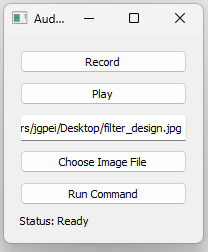

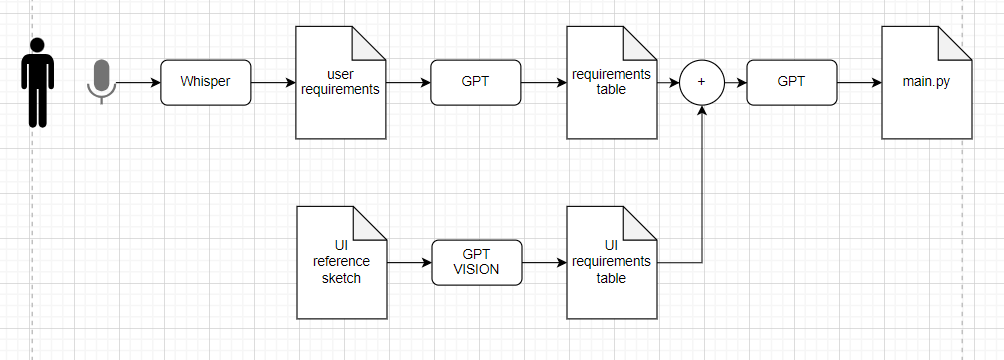

# Example 1: Date difference calculator:
#### User requirements:
This application computes the difference between three dates A, B and C, in days and shows the result of (C-B)-(B-A). It has three widgets to enter the dates in the form of YYYY-MM-DD and one widget to show the result.

#### UI sketch:
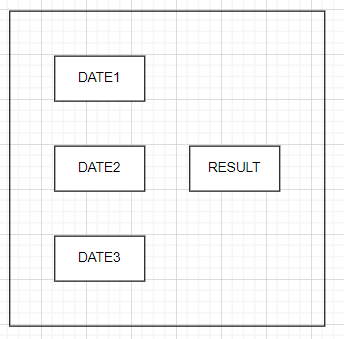

#### Result:
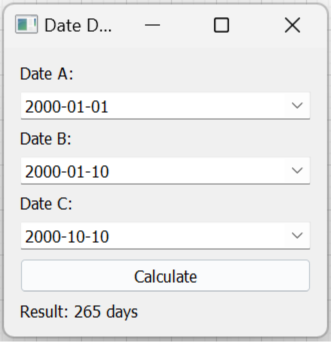

# Example 2: Amazon indoor thermometer
#### user requirements:
I want to make an application for a digital thermometer with a clock that shows on the screen the temperature and humidity in the upper part in large and the time and date in the lower part in small. I also want to show a bar in the central part that says if the environment is dry, comfortable or humid. This bar will mark dry when the humidity is less than 30%, comfortable between 30% and 70% and humid above 70%. Also, when it is dry, it will be orange, comfortable green and humid blue. To simulate the time and date, it will choose them from the system and the temperature and humidity, the application will show two sliders to simulate them.

#### UI sketch:
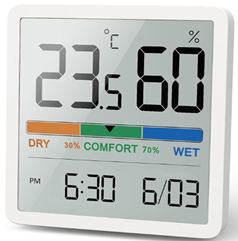

#### Results:
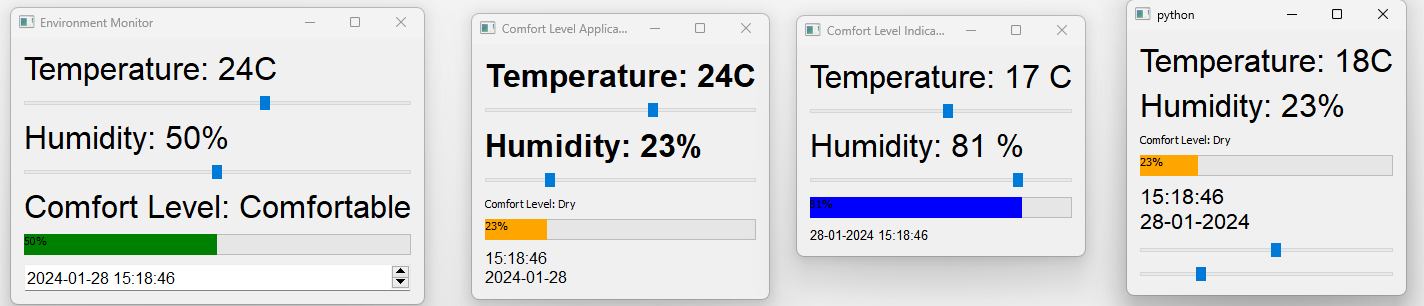

# Example 3: FIR filter designer
#### user requirements:
I want to make an application for the design of FIR filters. The application will have several settings on the left to introduce the parameters of the filter, a button to design and on the right two plots, one that shows the frequency response of the filter and another below that shows the response to the impulse and the response to the step. The settings on the left will be the type of filter that will be a combo box that will allow you to select between low pass filter, high pass filter and band pass filter, then an input text to select the lower cutoff frequency, then another input text to select the lower cutoff frequency, then another input text to select the transition band width and finally a button to make the design of the filter.

#### UI sketch:
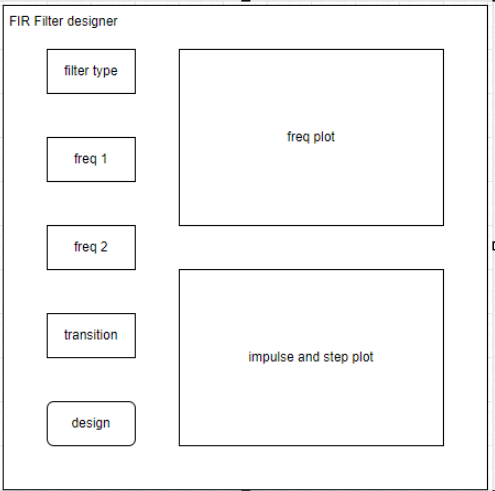

#### Detail of generated requirements and UI tables:
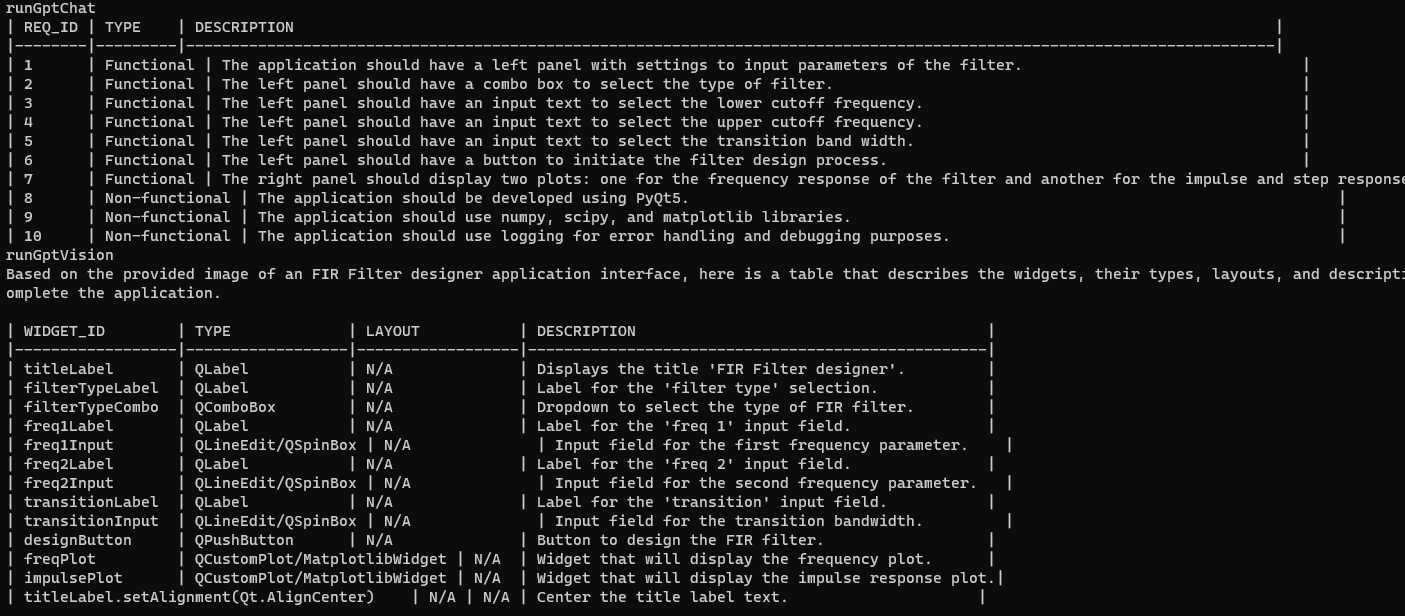

#### Results:
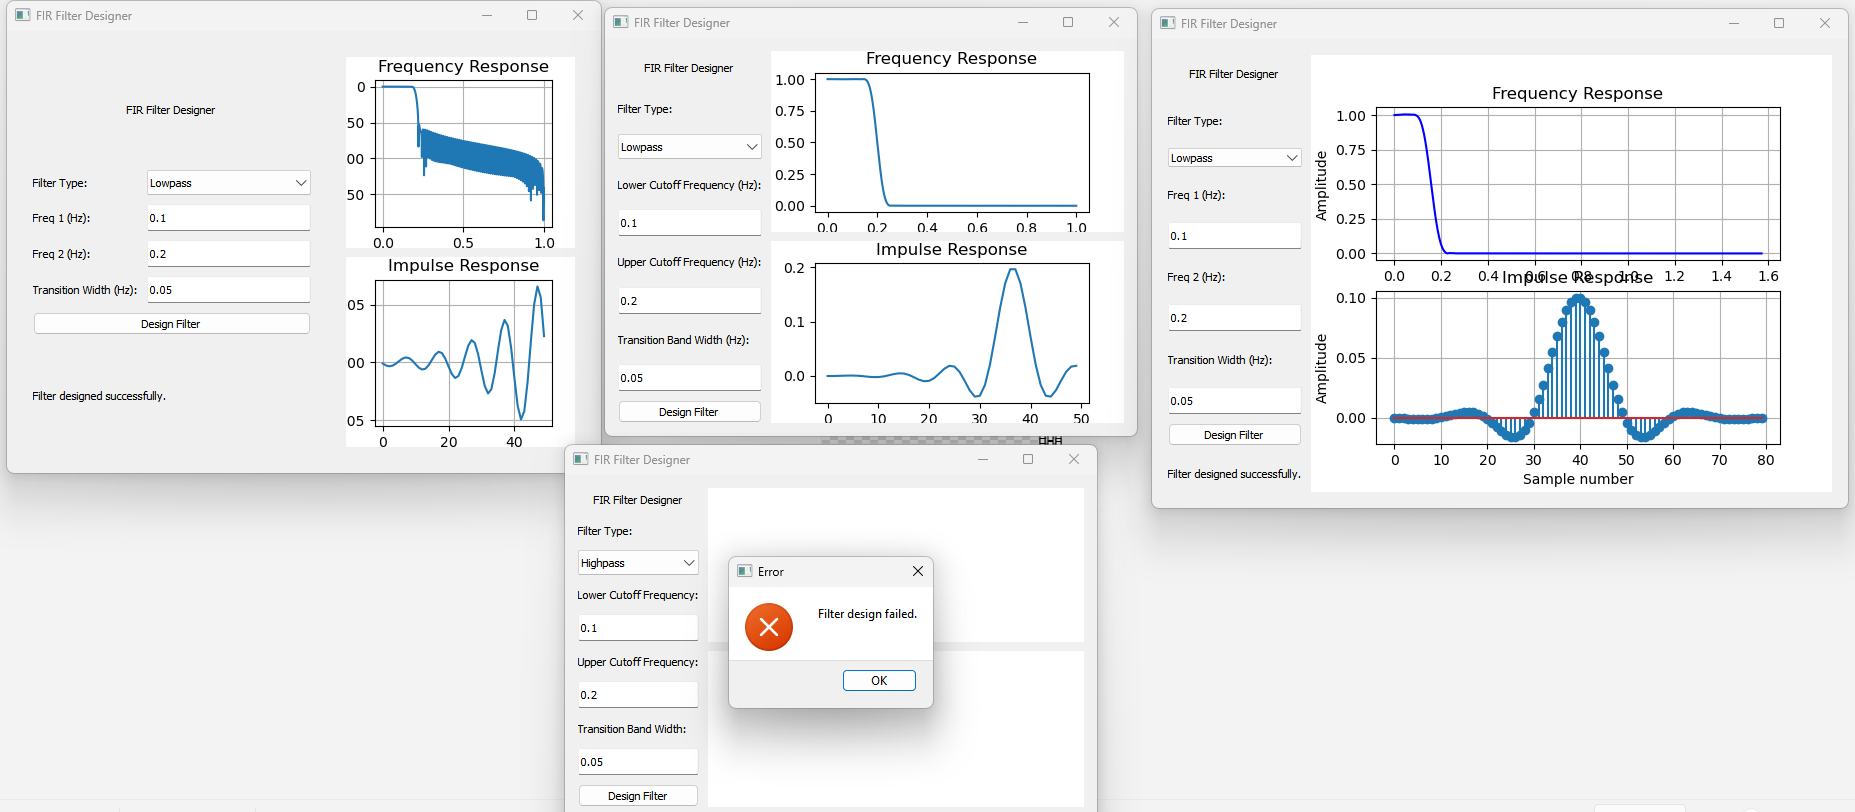

# Example 4: Serial terminal

#### user requirements:
I want to make a serial terminal application. The application will have several buttons at the top, to select the COM port, to select the BAU rate, to open and close the port, a long text area in the center and below a text input to select the text to send and a send button. The application will have a thread that will continuously read the serial port when it is open and will show the information in the terminal. Also, the information sent will be added to the terminal with the green color.

#### UI sketch:
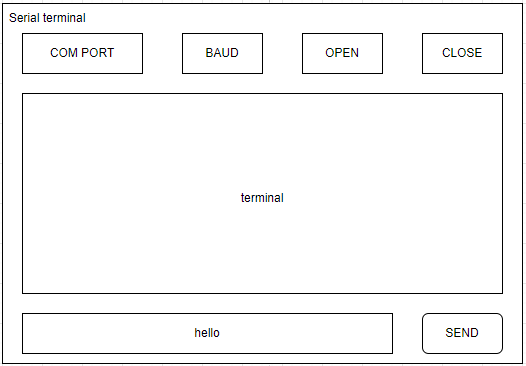

#### Result:
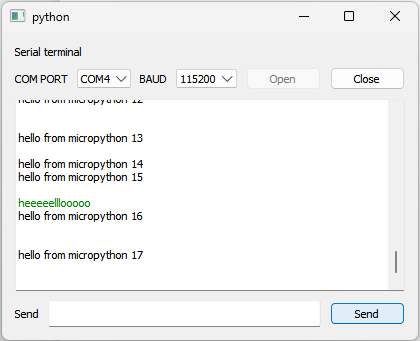

#### Details:
- As the GPT instructions require the use of the logging module, the generated apps are able to log their execution:
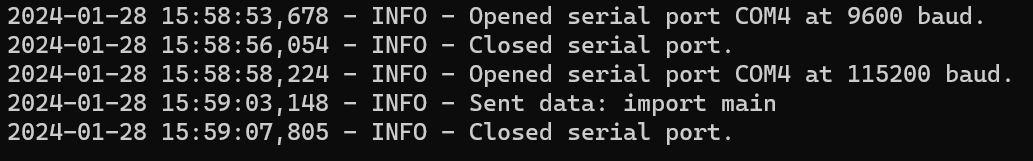


# Code quality:
- The code generated always looks very good
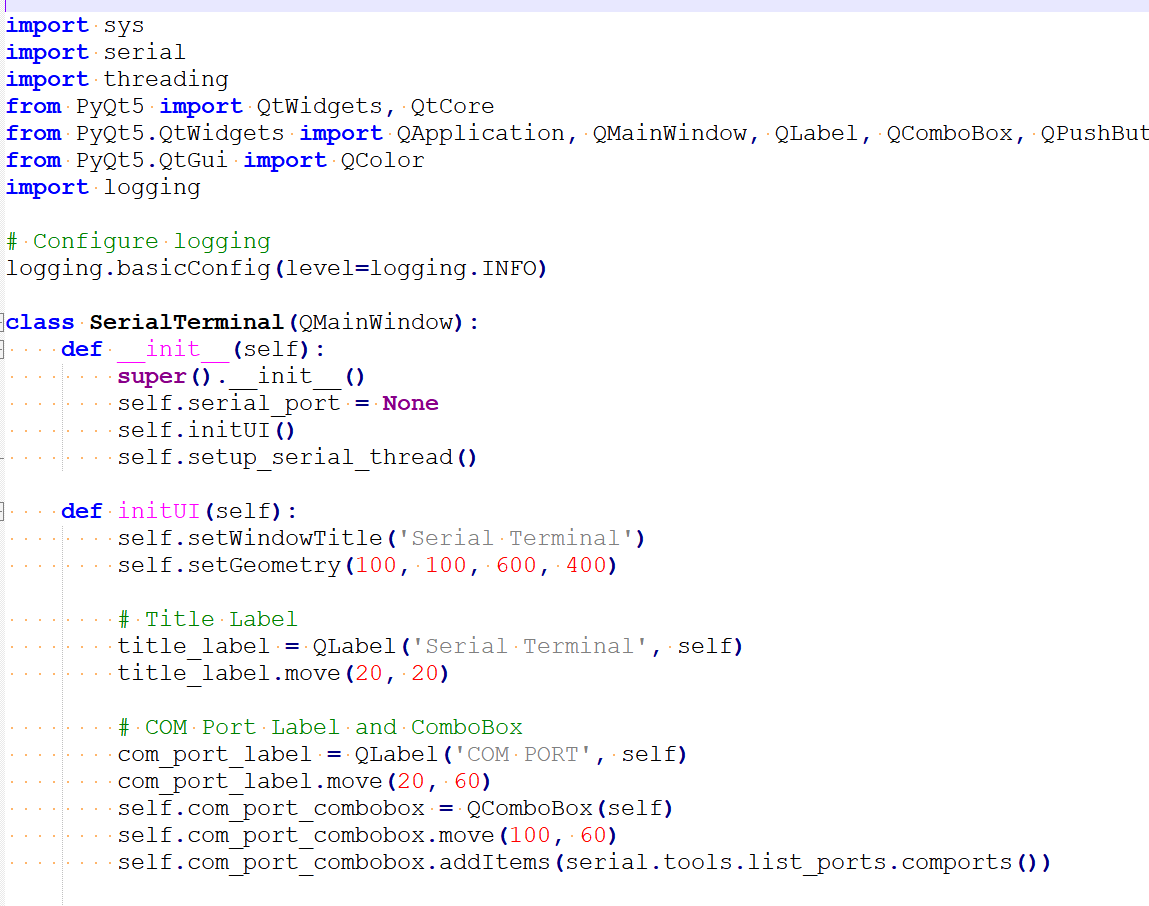

# Timming:
- Build each app takes about 1 minute

# Costs:
- All the apps builded here, costs about 1.25€ in API requests
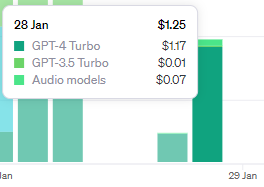

# Magic builder source code

In [ ]:
import time
import sys
import subprocess
import os
import threading
import pyaudio
import wave
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QLabel, QLineEdit, QFileDialog
from openai import OpenAI

API_KEY = '...'

def runSpeechToText(
    api_key, 
    model="whisper-1", 
    fl_name="output.wav"
):
    with OpenAI( api_key=api_key ) as client:
        audio_file = open( fl_name, "rb")
        transcript = client.audio.translations.create(
          model=model, 
          file=audio_file
        )
        response = transcript.text
    return response

def runGptChat(
    api_key, 
    model, 
    system_content, 
    user_content,
    assistant_content=None,
    max_tokens=8192
):
    messages = [
        {
            "role": "system",
            "content": system_content
        },
        {
            "role": "user",
            "content": user_content
        }
    ]
    if( assistant_content ):
        messages.append( 
            {
                "role": "assistant",
                "content": assistant_content
            }
        )

    with OpenAI( api_key=api_key ) as client:
        chat_completion = client.chat.completions.create(
            #model="gpt-3.5-turbo-16k",
            #model="gpt-3.5-turbo",
            model=model,
            #seed=0,
            temperature=0.5,
            top_p=1.0,
            max_tokens=max_tokens,
            messages=messages
        )
        response = chat_completion.choices[0].message.content
    return response



class AudioRecorderPlayer(QWidget):
    def __init__(self):
        super().__init__()
        
        self.audio_output_file = 'output.wav'

        self.audio = pyaudio.PyAudio()
        self.stop_event = threading.Event()

        self.is_recording = False
        self.is_playing = False

        self.record_button = QPushButton('Record', self)
        self.record_button.clicked.connect(self.toggle_record)

        self.play_button = QPushButton('Play', self)
        self.play_button.clicked.connect(self.toggle_play)

        self.line_edit = QLineEdit(self)
        self.file_button = QPushButton('Choose Image File', self)
        self.file_button.clicked.connect(self.choose_image_file)

        self.command_button = QPushButton('Run Command', self)
        self.command_button.clicked.connect(self.run_command)

        self.status_label = QLabel('Status: Ready', self)

        layout = QVBoxLayout(self)
        layout.addWidget(self.record_button)
        layout.addWidget(self.play_button)
        layout.addWidget(self.line_edit)
        layout.addWidget(self.file_button)
        layout.addWidget(self.command_button)
        layout.addWidget(self.status_label)

        self.setWindowTitle('Audio Recorder Player')
        self.setGeometry(100, 100, 300, 200)

    def choose_image_file(self):
        file_name, _ = QFileDialog.getOpenFileName(self, 'Open Image File', '', 'Image Files (*.bmp *.jpg *.png)')
        if file_name:
            self.line_edit.setText(file_name)
    
    def toggle_record(self):
        if not self.is_recording:
            self.is_recording = True
            self.record_button.setText('Stop Recording')
            self.play_button.setEnabled(False)
            self.command_button.setEnabled(False)
            self.status_label.setText('Status: Recording')

            self.stop_event.clear()
            self.record_thread = threading.Thread(target=self.record_audio)
            self.record_thread.start()
        else:
            self.is_recording = False
            self.record_button.setText('Record')
            self.play_button.setEnabled(True)
            self.command_button.setEnabled(True)
            self.status_label.setText('Status: Ready')
            self.stop_event.set()

    def record_audio(self):
        CHUNK = 1024
        FORMAT = pyaudio.paInt16
        CHANNELS = 2
        RATE = 44100

        stream = self.audio.open(
            format=FORMAT,
            channels=CHANNELS,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK
        )

        frames = []
        while not self.stop_event.is_set():
            data = stream.read(CHUNK)
            frames.append(data)

        stream.stop_stream()
        stream.close()

        self.audio_output_file = 'output.wav'
        wf = wave.open(self.audio_output_file, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(self.audio.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
        wf.close()

        print(f"Recording completed. Audio saved to {self.audio_output_file}")

    def toggle_play(self):
        if not self.is_playing:
            if hasattr(self, 'audio_output_file') and os.path.exists(self.audio_output_file):
                self.is_playing = True
                self.play_button.setText('Stop Playing')
                self.record_button.setEnabled(False)
                self.command_button.setEnabled(False)
                self.status_label.setText('Status: Playing')

                self.stop_event.clear()
                self.play_thread = threading.Thread(target=self.play_audio)
                self.play_thread.start()
            else:
                print("No recorded audio to play.")
        else:
            self.is_playing = False
            self.play_button.setText('Play')
            self.record_button.setEnabled(True)
            self.command_button.setEnabled(True)
            self.status_label.setText('Status: Ready')
            self.stop_event.set()

    def play_audio(self):
        wf = wave.open(self.audio_output_file, 'rb')

        stream = self.audio.open(format=self.audio.get_format_from_width(wf.getsampwidth()),
                                 channels=wf.getnchannels(),
                                 rate=wf.getframerate(),
                                 output=True)

        data = wf.readframes(1024)
        while data and not self.stop_event.is_set():
            stream.write(data)
            data = wf.readframes(1024)

        stream.stop_stream()
        stream.close()

        self.is_playing = False
        self.play_button.setText('Play')
        self.record_button.setEnabled(True)
        self.command_button.setEnabled(True)
        self.status_label.setText('Status: Ready')
        print("Playing completed.")
    
    def run_command(self):
        print( "run_command" )
        
        # Call Speech to Text
        print( "runSpeechToText" )
        user_requirements = runSpeechToText( 
            api_key=API_KEY, 
            model="whisper-1", 
            fl_name="output.wav"
        )
        print( user_requirements )
        
        print( "runGptChat" )
        response = runGptChat( 
            api_key=API_KEY, 
            model="gpt-3.5-turbo-16k",
            system_content="""
You are a python developer with experience on PyQt5, numpy, scipy, matplotlib and logging.
Instructions:
Analyze the user requirements and write a markdown table with rows: REQ_ID, TYPE, DESCRIPTION.
Add any missing requirement to complete the application.
""",
            user_content=user_requirements,
        )

        user_requirements = response
        print( user_requirements )
        
        image_path = self.line_edit.text()
        
        if( image_path ):
            import base64
            def encode_image(image_path):
                with open(image_path, "rb") as image_file:
                    return base64.b64encode(image_file.read()).decode('utf-8')
            
            base64_image = encode_image(image_path)
            
            print( "runGptVision" )
            with OpenAI( api_key=API_KEY ) as client:
                response = client.chat.completions.create(
                  model="gpt-4-vision-preview",
                  messages=[
                    {
                        "role": "system",
                        "content": """
You are a python developer with experience on PyQt5, numpy, scipy, matplotlib and logging.
Instructions:
Analyze the user requirements and write a markdown table with rows: WIDGET_ID, TYPE, LAYOUT, DESCRIPTION.
Add any missing widget to complete the application.
"""
                    },
                    {
                      "role": "user",
                      "content": [
                        {
                          "type": "image_url",
                          "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                          },
                        },
                      ],
                    },
                  ],
                  max_tokens=2048,
                )
                user_ui_requirements = response.choices[0].message.content
                if( "```markdown" in user_ui_requirements ):
                    print( '"```markdown" in user_ui_requirements' )
                    user_ui_requirements = user_ui_requirements.split("```markdown")[1].split("```")[0]
                print( user_ui_requirements )
        
        requirements = user_requirements + "\n" + user_ui_requirements + "\n"
        tasks = []
        for i in range( 1 ):
            tasks.append( threading.Thread( target=self.task, args=(requirements, i) ) )
        for task in tasks:
            task.start()
        for task in tasks:
            task.join()

    def task(self, user_requirements, number ):

        # Call GPT
        print( "runGptChat" )
        response = runGptChat( 
            api_key=API_KEY, 
            #model="gpt-3.5-turbo-16k",#"gpt-3.5-turbo-1106",
            model="gpt-4-1106-preview",
            system_content="""
You are a python developer with experience on PyQt5, numpy, scipy, matplotlib and logging.
Instructions:
Analyze the user requirements and write the application.
Add any missing code to complete the application.
Provide all the code required to run the application.
Avoid the use of TODOs in the response.
""",
            user_content=user_requirements,
            max_tokens=4000

        )
        print( response )
        
        # remove ```python XXX ``` from response
        if( "```python" in response ):
            print( '"```python" in response' )
            response = response.split("```python")[1].split("```")[0]
        
        # remove Non-UTF-8 characters
        if( not response.isascii() ):
            print( "not response.isascii()" )
            response = response.encode("ascii", "ignore").decode()

        # save response to main.py
        print( "save main_" + str(number) + ".py" )
        with open("main_" + str(number) + ".py", "w") as f:
            f.write(response)
        
        # execute main.py
        print("Running main_" + str(number) + ".py")
        subprocess.Popen([sys.executable, "main_" + str(number) + ".py"])
        print("done")
        

if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = AudioRecorderPlayer()
    window.show()
    sys.exit(app.exec_())


# Application prompts

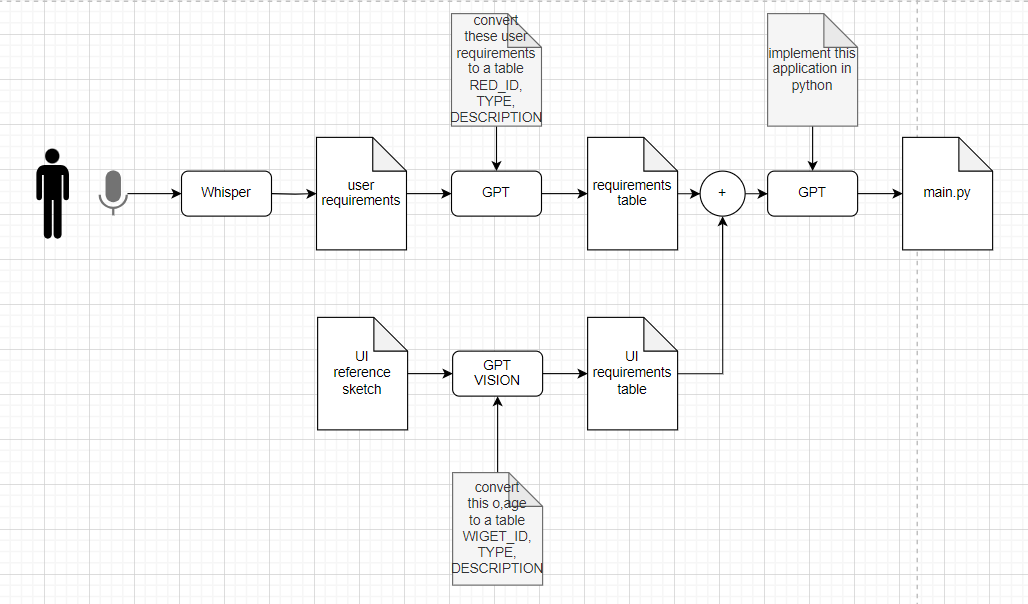

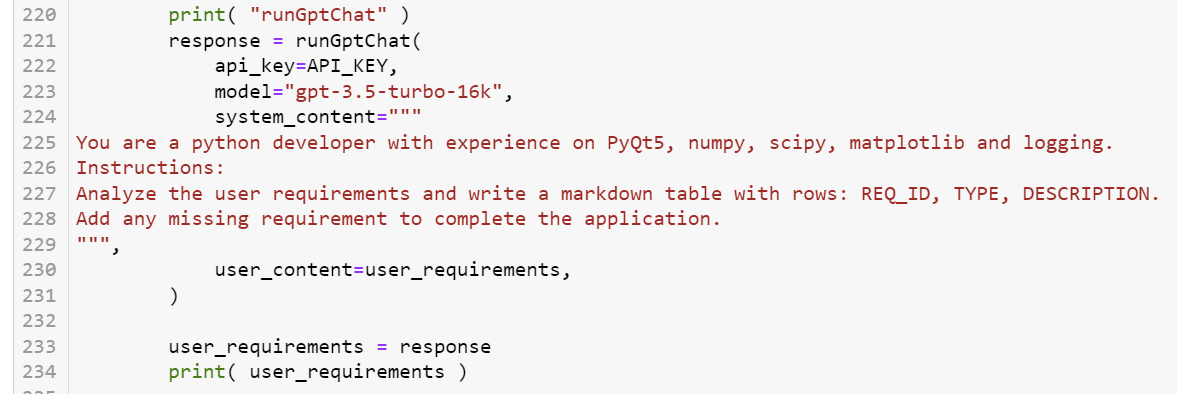

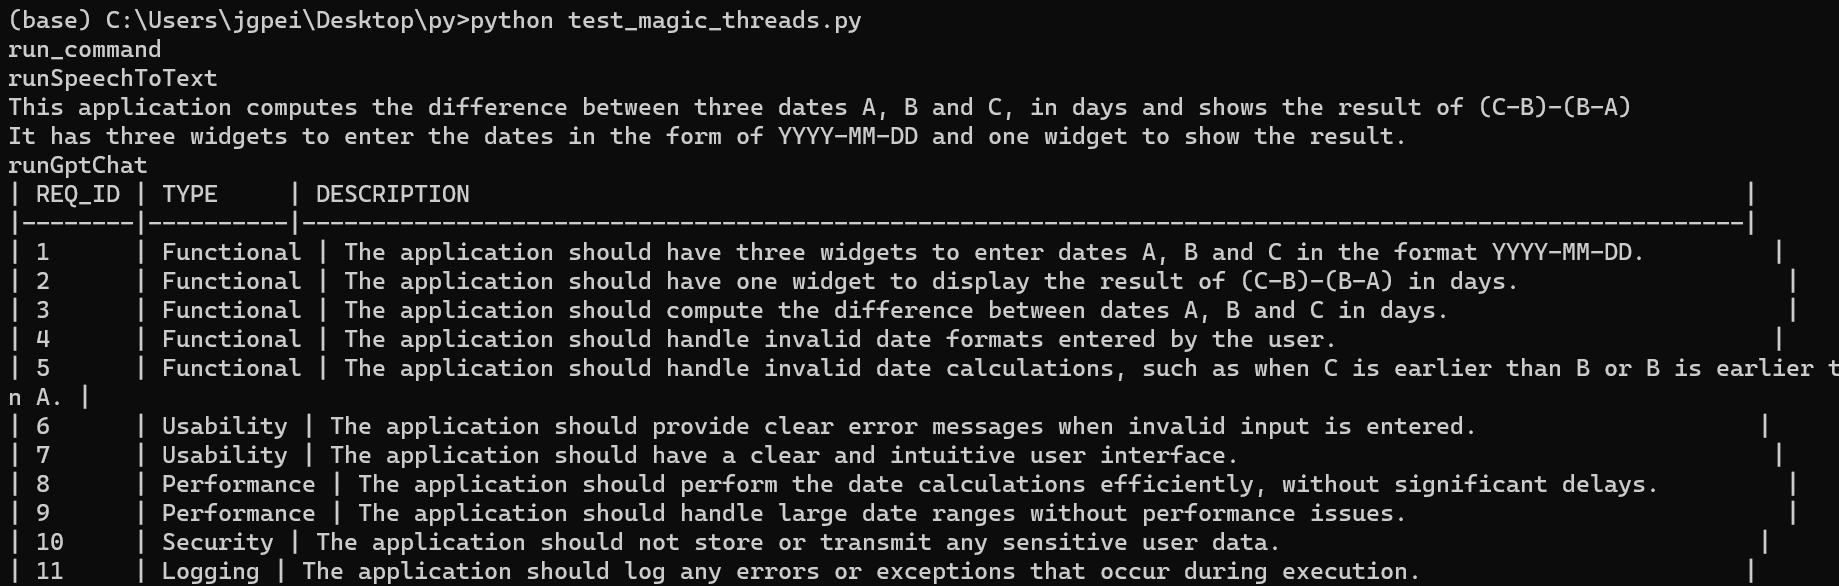